1. Build Charlson ICD9 Mapping

Researchers will often use CCI (Charlson Comorbidity Index) as a way to stratify patients into risk groups, e.g. 
* low risk: 0-1 
* medium risk: 2-3
* high risk: >= 4

We will do it manually 

In [ ]:
import pandas as pd

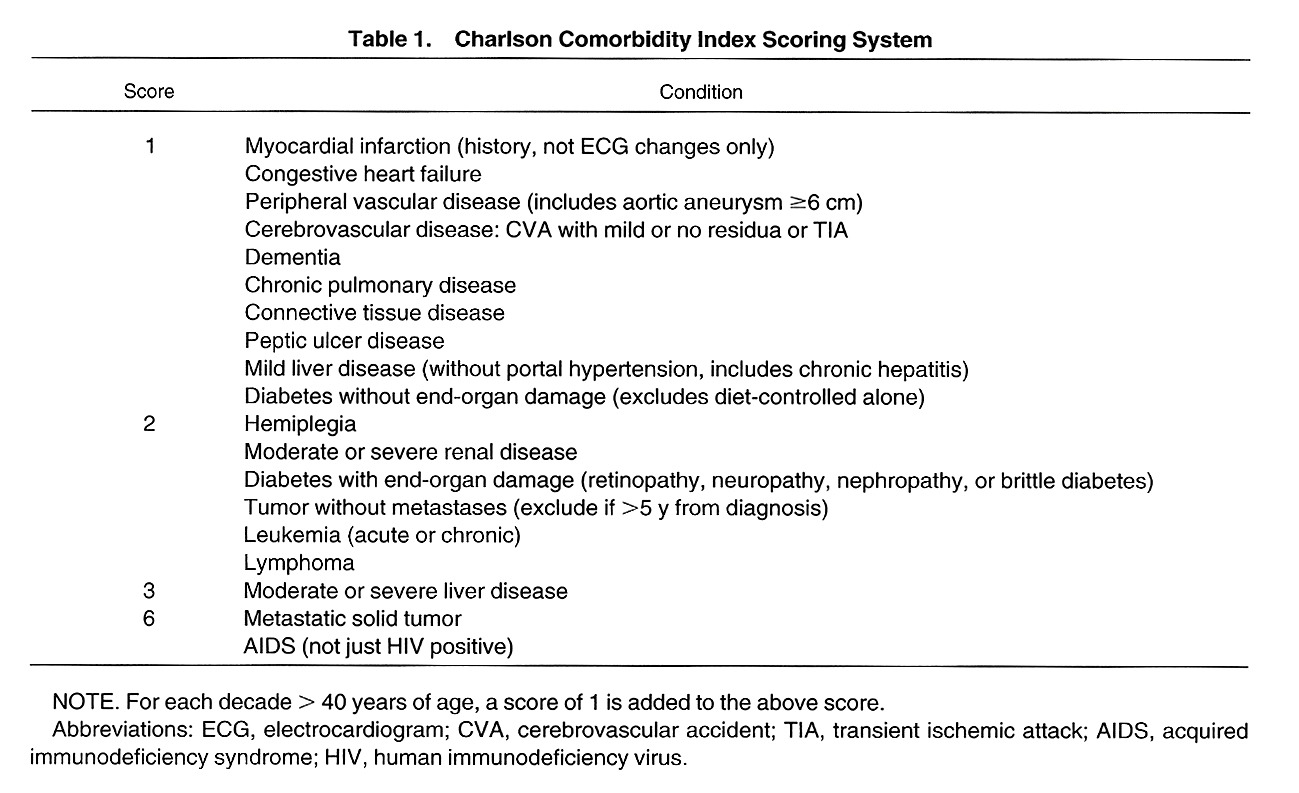

Source: http://nephron.org/cgi-bin/rpa_sdm.cgi

In [ ]:
## Maps and weights

## ICD9 --> Charlson category --> CCI score 

charlson_map = {
    'MI': ['410', '412'],
    'CHF': ['428'],
    'PVD': ['440', '441', '4439'],
    'CVD': [str(i) for i in range(430, 439)],  # 430–438
    'Dementia': ['290'],
    'COPD': ['490', '491', '492', '494', '496'],
    'Rheumatic': ['710', '714', '720'],
    'PUD': ['531', '532', '533', '534'],
    'MildLiver': ['5712', '5714', '5715', '5716'],
    'Diabetes': ['2500', '2501', '2502', '2503'],
    'DiabComp': ['2504', '2505', '2506', '2507'],
    'Paraplegia': ['342', '343', '344'],
    'Renal': ['582', '583', '585', '586', '588'],
    'Cancer': ([str(i) for i in range(140, 173)] + ## 140-172, and 174-199
               [str(i) for i in range(174, 200)]),
    'SevLiver': ['5722', '5723', '5724', '5728'],
    'Mets': ['196', '197', '198', '199'],
    'HIV': ['042', '043', '044']
    }

charlson_weights = {
    'MI': 1,
    'CHF': 1,
    'PVD': 1,
    'CVD': 1,
    'Dementia': 1,
    'COPD': 1,
    'Rheumatic': 1,
    'PUD': 1,
    'MildLiver': 1,
    'Diabetes': 1,
    'DiabComp': 2,
    'Paraplegia': 2,
    'Renal': 2,
    'Cancer': 2,
    'SevLiver': 3,
    'Mets': 6,
    'HIV': 6
}



In [ ]:
## Step two: detect the charlson map inside the icd codes (i.e. conduct the mapping)

def map_icd_to_charlson(icd9):
    ## Handle NA first:
    if pd.isna(icd9):
        return None

    ## clean icd first: remove the dot 
    icd9_cleaned = str(icd9).replace('.', '')

    ## loop through all the charlson mappings and check if exists in the icd code until first detection
    for category, prefix in charlson_map.items():
        ## loop through each category's list
        for pref in prefix:
            if str(icd9).startswith(pref):
                return category
    return None 

In [ ]:
# df= pd.read_parquet('data/curated/patients_admissions.parquet')
diagnosis = pd.read_parquet('data/cleaned/diagnosis_cleaned.parquet')


In [ ]:
## Apply 

diagnosis.head()

In [ ]:
diagnosis['charlson_category'] = diagnosis.icd9_code.apply(map_icd_to_charlson)

## Check 
diagnosis['charlson_category'].value_counts(dropna = False)

Most were not mapped to a certain Charlson category -- the CCI only accounts for 17 comorbidity categories (MI, diabetes, cancer), and does not cover injuries, procedures, and some conditions. 

In [ ]:
## Aggregate per admission (multiple diagnosis and hence charlson categories) and find score per admission

## 1. Find the list of charlson cats per admission
comorb_per_admission = diagnosis.dropna(subset=['charlson_category']).groupby(['subject_id', 'hadm_id'])['charlson_category'].unique().reset_index()


In [ ]:
## 2. Find the sum of weights 
comorb_per_admission['admission_CCI'] = comorb_per_admission.charlson_category.apply(lambda x: sum(charlson_weights.get(cat,0) for cat in x))

In [ ]:
## Check 
comorb_per_admission.head()

In [ ]:
print(f'Number of admissions with a valid CCI: {comorb_per_admission.shape[0]}')
print(f'Number of total admissions : {(diagnosis.hadm_id.nunique())}')

## Transform 

In [ ]:
## Merge into mastersheet
import os 

os.listdir('data/curated/')

In [ ]:
ipa = pd.read_parquet('data/curated/' + 'icu_patients_admissions.parquet')

In [ ]:
## Merge

ipa.head()

In [ ]:
print(ipa.shape[0])
ipa_charlson_diagoses = ipa.merge(comorb_per_admission, on = ['subject_id', 'hadm_id'], how = 'left')
print(ipa_charlson_diagoses.shape[0])

In [ ]:
## CHeck 
ipa_charlson_diagoses.head()

In [ ]:
## Cleaning -- fill NaNs with 0
ipa_charlson_diagoses.admission_CCI = ipa_charlson_diagoses.admission_CCI.fillna(0)

In [ ]:
## Checks 
import matplotlib.pyplot as plt
ipa_charlson_diagoses.admission_CCI.value_counts().plot(kind = 'bar')
plt.title('distribution of CCI scores (per admission)')
plt.show()

In [ ]:
## Save back to curated 
ipa_charlson_diagoses.to_parquet('data/curated/'+ 'icu_admissions_patients_charlson_diagnoses.parquet')

## Some CCI analysis

In [ ]:
admission_level = ipa_charlson_diagoses[['hadm_id', 'admission_CCI', 'hospital_expire_flag']].drop_duplicates()

# Compute mean and count per admission_CCI
grouped = admission_level.groupby('admission_CCI')['hospital_expire_flag']
means = grouped.mean()
counts = grouped.count()

# Plot the bar chart
plt.figure(figsize=(12, 6))
ax = means.plot(kind='bar')

# Annotate each bar with the sample size
for i, count in enumerate(counts):
    cci = means.index[i]
    ax.text(i, means[cci] + 0.01,   # position: x=i, y=bar height + small offset
            f'n={count}', 
            ha='center', va='bottom', fontsize=9, color='black')

plt.ylabel('Mean hospital_expire_flag')
plt.title('Hospital Expire Flag by Admission CCI (with sample sizes)')
plt.show()

There are fewer patients as the CCI increases, and the proportion of hospital death increases logically. 

In [ ]:
admission_level.groupby('admission_CCI')['los']

In [ ]:
admission_level_los = ipa_charlson_diagoses[['hadm_id', 'admission_CCI', 'hospital_expire_flag', 'los']].drop_duplicates()

admission_level_los.groupby('admission_CCI')['los'].mean().plot(kind = 'bar')

In [ ]:
ipa_charlson_diagoses.columns

In [ ]:
ipa_charlson_diagoses.groupby('ethnicity_categorised')['admission_CCI'].mean().sort_values(ascending= False).plot(kind = 'bar')
plt.xlabel('Ethnicity group')
plt.ylabel('mean admission CCI')
plt.title('Severity of comorbidities per ethnic group')
plt.show()